# Shrinkage Methods

The subset selection methods described before involves using OLS to fit a linear model that contains a subset of the predictors. As an alternative, we can fit a model containing _all_ predictors using a technique that constrains or 'regularizes' the coefficient estimates, or equivalently, that _shrinks_ the coefficient estimates towards zero.

💻 Previously we were interested in finding the most parsimonious model for the following data set:

In [1]:
# env
import pandas as pd
import numpy as np
import patsy

# rd df
df = pd.read_stata('http://fmwww.bc.edu/ec-p/data/wooldridge/hprice2.dta')
df.head()

,price,crime,nox,rooms,dist,radial,proptax,stratio,lowstat,lprice,lnox,lproptax
0,24000.0,0.006,5.38,6.57,4.09,1.0,29.600000,15.300000,4.98,10.085810,1.682688,5.690360
1,21599.0,0.027,4.69,6.42,4.97,2.0,24.200001,17.799999,9.14,9.980402,1.545433,5.488938
2,34700.0,0.027,4.69,7.18,4.97,2.0,24.200001,17.799999,4.03,10.454500,1.545433,5.488938
3,33400.0,0.032,4.58,7.00,6.06,3.0,22.200001,18.700001,2.94,10.416310,1.521699,5.402678
4,36199.0,0.069,4.58,7.15,6.06,3.0,22.200001,18.700001,5.33,10.496790,1.521699,5.402678


We actually found out that the chosen model by 'best,' 'forward,' and 'backward' subset search was

$$
\texttt{lprice}=\beta_{0}+\beta_{1}\texttt{lnox}+\beta_{2}\texttt{lproptax}+\beta_{3}\texttt{crime}+\beta_{4}\texttt{rooms}+\beta_{5}\texttt{dist}+\beta_{6}\texttt{radial}+\beta_{7}\texttt{stratio}+\beta_{8}\texttt{lowstat}+e
$$

However this model excludes the possibility of interaction terms among the predictors. Instead consider a most complete potential model with _all_ possible cross-products among the regressors _after_ they are re-center at their mean, i.e.,

$$
\begin{aligned}
\texttt{lprice}&=\beta_{0}+\beta_{1}\texttt{lnox}+\beta_{2}\texttt{lproptax}+\beta_{3}\texttt{crime}+\beta_{4}\texttt{rooms}+\beta_{5}\texttt{dist}+\beta_{6}\texttt{radial}\\
&+\beta_{7}\texttt{stratio}+\beta_{8}\texttt{lowstat}+\beta_{9}(\texttt{lnox}-\mu_{\texttt{lnox}})(\texttt{lproptax}-\mu_{\texttt{lproptax}})\\
&+\beta_{10}(\texttt{lnox}-\mu_{\texttt{lnox}})(\texttt{crime}-\mu_{\texttt{crime}})+\ldots+\beta_{35}(\texttt{radial}-\mu_{\texttt{radial}})(\texttt{lowstat}-\mu_{\texttt{lowstat}})\\
&+\beta_{36}(\texttt{stratio}-\mu_{\texttt{stratio}})(\texttt{lowstat}-\mu_{\texttt{lowstat}})+e.
\end{aligned}
$$

In this model with over 4 times the original number of predictors, one has that $\beta_{2}$ represents the constant elasticity of home prices with respect to property tax at the _mean_ value, i.e. $\mu_{\texttt{predictor}}$, of the other $\texttt{predictor}$. Similar interpretations can be given to the coefficients multiplying the other predictors.

✍🏽 One can replace $\mu_{\texttt{predictor}}$ with other values of the $\texttt{predictor}$ that may be of interest.

💻 This block will add _all_ cross-products among the _demeaned_ set of predictors to the original data frame.

In [2]:
# mk demeaned vars
tmp = ['lnox','lproptax','crime','rooms','dist','radial','stratio','lowstat']
for x in tmp:
    df[x+'_dmean'] = df[x] - df[x].mean(skipna = True)
print(list(df))

['price', 'crime', 'nox', 'rooms', 'dist', 'radial', 'proptax', 'stratio', 'lowstat', 'lprice', 'lnox', 'lproptax', 'lnox_dmean', 'lproptax_dmean', 'crime_dmean', 'rooms_dmean', 'dist_dmean', 'radial_dmean', 'stratio_dmean', 'lowstat_dmean']


💻 This code will create both model specifications

In [3]:
# mk interact trms
tmpstr = []
for x in range(len(tmp)):
    for y in tmp[x+1:]:
        if x != y:
            tmpstr.append('('+tmp[x]+'_dmean:'+y+'_dmean'+')')
    
# mk specifications str
f1 = 'lprice ~ -1 +' + ''.join([x+'+' for x in tmp])[:-1]
f2 = f1 + ' + ' + ''.join([x+'+' for x in tmpstr])[:-1] 

# prt specifications str
print(f1)
print(f2)

lprice ~ -1 +lnox+lproptax+crime+rooms+dist+radial+stratio+lowstat
lprice ~ -1 +lnox+lproptax+crime+rooms+dist+radial+stratio+lowstat + (lnox_dmean:lproptax_dmean)+(lnox_dmean:crime_dmean)+(lnox_dmean:rooms_dmean)+(lnox_dmean:dist_dmean)+(lnox_dmean:radial_dmean)+(lnox_dmean:stratio_dmean)+(lnox_dmean:lowstat_dmean)+(lproptax_dmean:crime_dmean)+(lproptax_dmean:rooms_dmean)+(lproptax_dmean:dist_dmean)+(lproptax_dmean:radial_dmean)+(lproptax_dmean:stratio_dmean)+(lproptax_dmean:lowstat_dmean)+(crime_dmean:rooms_dmean)+(crime_dmean:dist_dmean)+(crime_dmean:radial_dmean)+(crime_dmean:stratio_dmean)+(crime_dmean:lowstat_dmean)+(rooms_dmean:dist_dmean)+(rooms_dmean:radial_dmean)+(rooms_dmean:stratio_dmean)+(rooms_dmean:lowstat_dmean)+(dist_dmean:radial_dmean)+(dist_dmean:stratio_dmean)+(dist_dmean:lowstat_dmean)+(radial_dmean:stratio_dmean)+(radial_dmean:lowstat_dmean)+(stratio_dmean:lowstat_dmean)


💻 This code uses the ```patsy``` library to create the corresponding outcome vector and design matrices for both specifications.

In [4]:
y1, X1 = patsy.dmatrices(f1, data=df, return_type='dataframe')
y2, X2 = patsy.dmatrices(f2, data=df, return_type='dataframe')

💻 This code will create the indices for the train (80%) and validation (20%) data sets.

In [5]:
from sklearn.model_selection import train_test_split
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.20, random_state=42)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.20, random_state=42)

## _Ridge_ Regression

The _traditional_ motivation is to reduce the degree of collinearity among the regressors. The _modern_ motivation is regularization of high-dimensional and ill-posed inverse problems.

<p style='text-align: right;'> <a href="https://en.wikipedia.org/wiki/Tikhonov_regularization" style="color: #cc0000">Tikhonov Regularization</a></p>

#### Traditional Motivation

Take a linear regression model $y_{i}=\mathbf{x}_{i}^{\prime} \boldsymbol{\beta}+e_{i}$. In "machine learning" applications the dimension of $\boldsymbol{\beta}$ can be very large, and often the regressors are highly correlated. In these cases the least squares estimator may be undefined and/or the $\mathbf{X}^{\prime}\mathbf{X}$ matrix ill-conditioned, which can mean that the least squares coefficient estimates are numerically unreliable. As a numerical solution to this dilemma, Hoerl and Kennard (1970) proposed the ridge regression estimator

$$\widehat{\boldsymbol{\beta}}_{\text {ridge}}=\left(\mathbf{X}^{\prime} \mathbf{X}+\lambda \mathbf{I}_{k}\right)^{-1} \mathbf{X}^{\prime} \mathbf{y}$$

where <span style="color:blue">$\lambda>0$</span> is a shrinkage parameter and treated later on as a <span style="color:blue">tuning parameter</span>.

✍🏽 The ridge regression estimator has the property that it is well-defined and does not suffer from multicollinearity or ill-conditioning so long as $\lambda>0$. This even holds if $k>n$! That is, the ridge regression estimator can be calculated even when the number of regressors exceeds the sample size.

***
To see how $\lambda>0$ ensures that the inverse problem is solved, use the spectral decomposition to write $\mathbf{X}^{\prime} \mathbf{X}=\mathbf{H}^{\prime}\mathbf{D}\mathbf{H}$ where $\mathbf{H}$ is orthonormal and $\mathbf{D}=\text{diag}\left\{r_{1}, \ldots, r_{k}\right\}$ is a diagonal matrix with the eigenvalues $r_{j}$ of $\mathbf{X}^{\prime} \mathbf{X}$ on the diagonal. Let $\Lambda=\lambda \mathbf{I}_{k}$. We can write
$$
\mathbf{X}^{\prime} \mathbf{X}+\lambda \mathbf{I}_{k}=\mathbf{H}^{\prime} \mathbf{D} \mathbf{H}+\lambda \mathbf{H}^{\prime} \mathbf{H}=\mathbf{H}^{\prime} \mathbf{D} \mathbf{H}+\mathbf{H}^{\prime} \Lambda \mathbf{H}=\mathbf{H}^{\prime}(\mathbf{D}+\Lambda) \mathbf{H}
$$
which has eigenvalues $r_{j}+\lambda>0$. Thus all eigenvalues are bounded away from zero so $\mathbf{X}^{\prime} \mathbf{X}+\lambda \mathbf{I}_{k}$ is full
rank and therefore invertible.

<p style='text-align: right;'> <a href="https://en.wikipedia.org/wiki/Eigendecomposition_of_a_matrix" style="color: #cc0000">Spectral Decomposition of a Matrix</a></p>

<p style='text-align: right;'> <a href="https://en.wikipedia.org/wiki/Orthogonal_matrix" style="color: #cc0000">Orthonormal Matrix</a></p>

<p style='text-align: right;'> <a href="https://en.wikipedia.org/wiki/Diagonal_matrix" style="color: #cc0000">Diagonal Matrix</a></p>

***

#### Modern Motivation

The second motivation is based on penalization. When $\mathbf{X}^{\prime}\mathbf{X}$ is ill-conditioned computing its inverse is "ill-posed." Techniques to deal with ill-posed estimators are called "regularization" and a leading method is penalization. Consider the penalized regression criterion (Sum of Squared Errors)

$$
\begin{aligned}\text{SSE}_2(\mathbf{b}, \lambda) &=(\mathbf{y}-\mathbf{X} \mathbf{b})^{\prime}(\mathbf{y}-\mathbf{X} \mathbf{b})+\lambda \mathbf{b}^{\prime} \mathbf{b} \\ &=\|\mathbf{y}-\mathbf{X} \mathbf{b}\|_{2}^{2}+\lambda\|\mathbf{b}\|_{2}^{2} \end{aligned}
$$

where $\|\mathbf{a}\|_{2}=\left(\mathbf{a}^{\prime} \mathbf{a}\right)^{1 / 2}$ is the $L_2$-norm. The minimizer of $\mathrm{SSE}_2(\mathbf{b}, \lambda)$ is a regularized least squares estimator. The first order condition for minimization of $\mathrm{SSE}_{2}(\mathbf{b}, \lambda)$ over $\mathbf{b}$ is

$$
-2 \mathbf{X}^{\prime}(\mathbf{y}-X \mathbf{b})+2 \lambda \mathbf{b}=0
$$

<p style='text-align: right;'> <a href="https://en.wikipedia.org/wiki/Euclidean_distance" style="color: #cc0000">$L_2$-norm</a></p>

The solution is $\widehat{\boldsymbol{\beta}}_{\text {ridge }}$. Thus the regularized (penalized) least squares estimator equals ridge regression. This shows that the ridge regression estimator minimizes the sum of squared errors subject to a penalty on the $L_2$-norm magnitude of the regression coefficient. Penalizing large coefficient vectors keeps the latter from being too large and erratic. _Hence one interpretation of $\lambda$ is the degree of penalty on the
magnitude of the coefficient vector._

***
Minimization subject to a penalty has a dual representation as constrained minimization. The latter is

$$
\min _{\mathbf{b}}(\mathbf{y}-\mathbf{X} \mathbf{b})^{\prime}(\mathbf{y}-\mathbf{X} \mathbf{b})
$$

subject to $\mathbf{b}^{\prime} \mathbf{b} \leq \tau$, for some $\tau>0$. To see the connection, the Lagrangian for the constrained problem is
$$
\min _{\mathbf{b}}(\mathbf{y}-\mathbf{X} \mathbf{b})^{\prime}(\mathbf{y}-\mathbf{X} \mathbf{b})+\lambda\left(\mathbf{b}^{\prime} \mathbf{b}-\tau\right),
$$

where $\lambda$ is a [Lagrange multiplier](https://en.wikipedia.org/wiki/Lagrange_multiplier).

The practical difference between the penalization and constraint problems is that in the first you specify the ridge parameter $\lambda$ while in the second you specify the constraint $\tau$. They are connected, since the values of $\lambda$ and $\tau$ satisfy the relationship

$$
\mathbf{y}^{\prime} \mathbf{X}\left(\mathbf{X}^{\prime} \mathbf{X}+\lambda \mathbf{I}_{k}\right)^{-1}\left(\mathbf{X}^{\prime} \mathbf{X}+\lambda \mathbf{I}_{k}\right)^{-1} \mathbf{X}^{\prime} \mathbf{y}=\tau.
$$

Thus to find $\lambda$ given $\tau$ it is sufficient to (numerically) solve this equation.
***

<img src="img/ridge.png" alt="drawing" width="500"/>

This figure help us visualize the constraint problem as it plots an example in $\mathbb{R}^2$. The constraint set $\mathbf{b}^\prime\mathbf{b}\le\tau$ is displayed as the ball about the origin and the contour sets of the $\mathrm{SSE}$ are displayed as ellipses. The least squares estimator is the center of the ellipses, while the ridge regression
estimator is the point on the circle where the contour is tangent. This shrinks the least squares coefficient towards the zero vector. It shrinks along a trajectory determined by the degree of correlation between the variables. This trajectory is displayed with the dashed lines, marked as 'Ridge path'. This is the sequence of ridge regression coefficients obtained as $\lambda$ (or $\tau$) is varied from small to large. When $\lambda=0$ (or $\tau$ is large) the ridge estimator equals least squares. For small $\lambda$ the ridge estimator moves slightly towards the origin by sliding along the ridge of the contour set. As $\lambda$ increases the ridge estimator takes a more direct path towards the origin.

<p style='text-align: right;'> <a href="https://en.wikipedia.org/wiki/Real_coordinate_space" style="color: #cc0000">$\mathbb{R}^2$</a></p>

💻 In these set of commands the Ridge estimators are calculated for a sequence of values of $\lambda$ and we observe their performance

In [6]:
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.metrics import mean_squared_error

💻 The ```Ridge()``` function has an alpha argument ($\lambda$, but with a different name!) that is used to tune the model. We'll generate an array of alpha values ranging from very big to very small, essentially covering the full range of scenarios from the null model containing only the intercept, to the least squares fit:

In [7]:
alphas = np.linspace(0,4,20)
alphas

array([0.        , 0.21052632, 0.42105263, 0.63157895, 0.84210526,
       1.05263158, 1.26315789, 1.47368421, 1.68421053, 1.89473684,
       2.10526316, 2.31578947, 2.52631579, 2.73684211, 2.94736842,
       3.15789474, 3.36842105, 3.57894737, 3.78947368, 4.        ])

In [8]:
ridge = Ridge(normalize = True)
coefs = []

for a in alphas:
    ridge.set_params(alpha = a,fit_intercept=True)
    ridge.fit(X2, y2)
    coefs.append(ridge.coef_)
    
coefs = pd.DataFrame(np.array(coefs).transpose(2,0,1).reshape(36,-1))

We expect the coefficient estimates to be much smaller when a large value of alpha is used, as compared to when a small value of alpha is used. Let's plot and find out:

Text(0, 0.5, 'rooms')

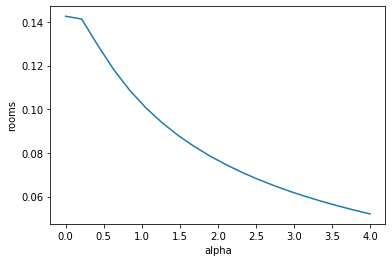

In [9]:
import matplotlib.pyplot as plt
ax = plt.gca()
ax.plot(alphas, coefs.iloc[3])
plt.xlabel('alpha')
plt.ylabel(np.array(list(X2))[3])

💻 Next we fit a ridge regression model on the training set, and evaluate its MSE on the test set, using  $\lambda=4$ :

In [10]:
ridge2 = Ridge(alpha = 4, normalize = True)
ridge2.set_params(fit_intercept=True)
ridge2.fit(X2_train, y2_train)             # Fit a ridge regression on the training data
pred2 = ridge2.predict(X2_test)            # Use this model to predict the test data
print(pd.Series(np.array(ridge2.coef_).transpose(1,0).tolist(), index = X2_train.columns)) # Print coefficients
print(mean_squared_error(y2_test, pred2))          # Calculate the test MSE

lnox                               [-0.10613438357364502]
lproptax                           [-0.05104701207585072]
crime                            [-0.0016574433515859851]
rooms                               [0.05297157650141043]
dist                              [0.0057655789741458425]
radial                           [-0.0015486050262700736]
stratio                           [-0.010009701824116255]
lowstat                            [-0.00588118489640561]
lnox_dmean:lproptax_dmean          [-0.10175167341671203]
lnox_dmean:crime_dmean            [-0.006055985481705164]
lnox_dmean:rooms_dmean              [-0.0283676828601138]
lnox_dmean:dist_dmean              [0.007121312469049626]
lnox_dmean:radial_dmean          [-0.0033762950772312913]
lnox_dmean:stratio_dmean           [0.004257224159789088]
lnox_dmean:lowstat_dmean          [-0.008941649678460143]
lproptax_dmean:crime_dmean       [-0.0021845174225613795]
lproptax_dmean:rooms_dmean        [-0.045848968726306234]
lproptax_dmean

Instead of arbitrarily choosing $\lambda=4$ , it would be better to use cross-validation to choose the tuning parameter alpha. We can do this using the cross-validated ridge regression function, ```RidgeCV()```. By default, the function performs generalized cross-validation (an efficient form of LOOCV), though this can be changed using the argument cv.

In [11]:
ridgecv = RidgeCV(alphas = alphas+0.01, scoring = 'neg_mean_squared_error', normalize = True)
ridgecv.set_params(fit_intercept=True)
ridgecv.fit(X2_train, y2_train)
ridgecv.alpha_

0.01

Therefore, we see that the value of alpha that results in the smallest cross-validation error is 0.01. What is the test MSE associated with this value of alpha?

In [12]:
ridge4 = Ridge(alpha = ridgecv.alpha_, normalize = True)
ridge4.set_params(fit_intercept=True)
ridge4.fit(X2_train, y2_train)
mean_squared_error(y2_test, ridge4.predict(X2_test))

0.02568595544251021

In [13]:
ridge4.fit(X2, y2)
print(pd.Series(np.array(ridge4.coef_).transpose(1,0).tolist(), index = X2.columns)) # Print coefficients

lnox                               [-0.5637617006991203]
lproptax                          [-0.17629706397833975]
crime                            [-0.001230657114430539]
rooms                              [0.14190076560008608]
dist                              [-0.04900448452279154]
radial                            [0.007529085595111794]
stratio                          [-0.023277895035797525]
lowstat                          [-0.026432425461879856]
lnox_dmean:lproptax_dmean           [0.6154861818117473]
lnox_dmean:crime_dmean              [-0.070480493191344]
lnox_dmean:rooms_dmean              [0.0900547741092687]
lnox_dmean:dist_dmean           [-0.0008569591533679481]
lnox_dmean:radial_dmean          [-0.012996638464387705]
lnox_dmean:stratio_dmean          [0.009446884642289462]
lnox_dmean:lowstat_dmean          [-0.01580301862811475]
lproptax_dmean:crime_dmean         [0.00851942022217377]
lproptax_dmean:rooms_dmean       [-0.015221948975572504]
lproptax_dmean:dist_dmean      

✍🏽 As expected, none of the coefficients are exactly zero - ridge regression does not perform variable selection. One disadvantage of the ridge regression is that, it will include _all_ the predictors in the final model. Ridge regression shrinks the coefficients towards zero, but it will not set any of them exactly to zero.

## _Lasso_ Regression

The LASSO stands for **Least Absolute Shrinkage and Selection Operator**. It shrinks the regression coefficients towards zero by penalizing the regression model with a $L_1$ penalty. The $L_{1}$ penalized least squares criterion is
$$
\begin{aligned} \mathrm{SSE}_{1}(\mathbf{b}, \lambda) &=(\mathbf{y}-\mathbf{X} \mathbf{b})^{\prime}(\mathbf{y}-\mathbf{X} \mathbf{b})+\lambda \sum_{j=1}^{k}\left|\beta_{j}\right| \\ &=\|\mathbf{y}-\mathbf{X} \mathbf{b}\|_{2}^{2}+\lambda\|\mathbf{b}\|_{1}, \end{aligned}
$$
where $\|\mathbf{a}\|_{1}=\sum_{j=1}^{k}\left|a_{j}\right|$ is the $L_{1}$-norm. The LASSO estimator is then defined as
$$
\widehat{\boldsymbol{\beta}}_{\text{lasso}}=\underset{\mathbf{b}}{\text{arg min }} \mathrm{SSE}_{1}(\mathbf{b}, \lambda).
$$

<p style='text-align: right;'> <a href="https://en.wikipedia.org/wiki/Taxicab_geometry" style="color: #cc0000">$L_1$-norm</a></p>

***
The LASSO minimization problem has the dual constrained optimization problem
$$
\widehat{\boldsymbol{\beta}}_{\text {lasso }}=\underset{\|\mathbf{b}\|_{1} \leq \tau}{\text{arg min } \mathrm{SSE}_1}(\mathbf{b}).
$$
To see that the two problems are the same observe that the constrained optimization problem has the Lagrangian
$$
\min _{\mathbf{b}}(\mathbf{y}-\mathbf{X} \mathbf{b})^{\prime}(\mathbf{y}-\mathbf{X} \mathbf{b})+\lambda\left(\sum_{j=1}^{k}\left|b_{j}\right|-\tau\right)
$$
which has first order conditions
$$
-2 \mathbf{x}_{j}^{\prime}(\mathbf{y}-\mathbf{X} \mathbf{b})+\lambda \text{ sgn}\left(b_{j}\right)=0
$$

<p style='text-align: right;'> <a href="https://en.wikipedia.org/wiki/Sign_function" style="color: #cc0000">Sign Function</a></p>

which are the same as those for minimization of the penalized criterion. Thus the solutions are identical.

***

<img src="img/lasso.png" alt="drawing" width="500"/>

The constrained minimization problem in $\mathbb{R}^2$ is shown here. As one can see the constraint set $\left\{\|\mathbf{b}\|_{1} \leq \tau\right\}$ for the dual problem is a cross-polytope, resembling a multi-faceted diamond. As before the sum of squared error contour sets are the ellipses with the least squares solution at the center. The constraint set is the shaded polytope. The LASSO estimator is the intersection point between the constraint set and the largest ellipse drawn, and in this example hits a vertex of the constraint set, and so the constrained estimator sets $\widehat{\beta}_1=0$. This is a typical outcome in LASSO estimation. Since we are minimizing a quadratic subject to a polytope constraint, the solution tends to be at vertices which eliminate a subset of the coefficients.

The LASSO path is drawn with the dashed line. This is the sequence of solution paths obtained as the constraint set is varied. The solution path has the property that it is a straight line from the least squares estimator to the y-axis (in this example), at which point $\beta_1$ is set to zero, and then the solution path follows the y-axis to the origin. With a general number of coefficients the solution path has a similar property, where the solution path is linear on segments until each coefficient hits zero, at which point it is eliminated. In this particular example the solution path shows $\beta_2$ increasing while $\beta_1$ decreases. Thus while LASSO is a shrinkage estimator it does not necessarily shrink the individual coefficients monotonically.

💻 In these set of commands the LASSO estimators are calculated for a sequence of values of $\lambda$ and we observe their performance. In order to fit a lasso model, we use the ```Lasso()``` function; however, this time the argument ```max_iter = 10000``` is included. Other than that change, we proceed just as we did in fitting a ridge model:

In [14]:
from sklearn.linear_model import Lasso, LassoCV

lasso = Lasso(max_iter = 10000, normalize=True)
coefs = []

alphas = np.linspace(0.001,0.005,20)
for a in alphas:
    lasso.set_params(alpha=a,fit_intercept=True)
    lasso.fit(X2_train, y2_train)
    coefs.append(lasso.coef_)

coefs = pd.DataFrame(np.array(coefs).transpose())

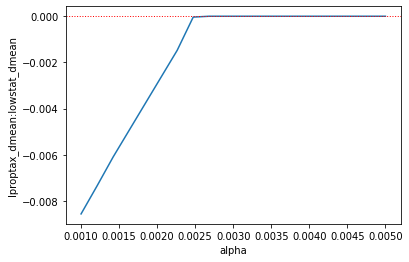

In [15]:
ax = plt.gca()
ax.plot(alphas, coefs.iloc[20])
plt.xlabel('alpha')
plt.ylabel(np.array(list(X2_train))[20])
plt.axhline(y=0,linewidth=1, color='r',linestyle=':')

Notice that in the coefficient plot that depending on the choice of tuning parameter, some of the coefficients are exactly equal to zero. We now perform 10-fold cross-validation to choose the best $\lambda$, refit the model, and compute the associated test error:

In [16]:
lassocv = LassoCV(alphas = list(alphas), cv = 10, max_iter = 100000)
lassocv.set_params(fit_intercept=True)
lassocv.fit(X2_train, y2_train.values.ravel()) # need .ravel() to avoid warning

lasso.set_params(alpha=lassocv.alpha_,fit_intercept=True)
lasso.fit(X2_train, y2_train.values.ravel())  # need .ravel() to avoid warning
mean_squared_error(y2_test, lasso.predict(X2_test))

0.0339334920092836

In [17]:
print(pd.Series(lasso.fit(X2_train, y2_train).coef_.tolist(), index = X2_train.columns)) # Print coefficients

lnox                           -0.011724
lproptax                       -0.068522
crime                          -0.000000
rooms                           0.134832
dist                           -0.000000
radial                         -0.000000
stratio                        -0.014916
lowstat                        -0.026896
lnox_dmean:lproptax_dmean      -0.000000
lnox_dmean:crime_dmean         -0.024746
lnox_dmean:rooms_dmean         -0.000000
lnox_dmean:dist_dmean           0.000000
lnox_dmean:radial_dmean        -0.000000
lnox_dmean:stratio_dmean        0.000000
lnox_dmean:lowstat_dmean       -0.000000
lproptax_dmean:crime_dmean     -0.000000
lproptax_dmean:rooms_dmean     -0.000000
lproptax_dmean:dist_dmean       0.000000
lproptax_dmean:radial_dmean     0.000000
lproptax_dmean:stratio_dmean    0.001225
lproptax_dmean:lowstat_dmean   -0.008556
crime_dmean:rooms_dmean         0.000000
crime_dmean:dist_dmean          0.000611
crime_dmean:radial_dmean       -0.000000
crime_dmean:stra

#### OLS vs Ridge vs LASSO: A Special Case

One case where we can explicitly calculate the LASSO estimates is when the regressors are orthogonal. Suppose that $\mathbf{X}^{\prime} \mathbf{X}=\mathbf{I}_{k}$ and $k<n$. Then the first order condition for minimization simplifies to

$$
-2\left(\widehat{\beta}_{\mathrm{ols}, j}-\widehat{\beta}_{\text{lasso}, j}\right)+\lambda \text{ sgn}\left(\widehat{\beta}_{\text{lasso}, j}\right)=0
$$

which has the explicit solution

$\widehat{\beta}_{\text {lasso, } j}=\left\{\begin{array}{ll}{\widehat{\beta}_{\text {ols, }, j}-\lambda / 2} & {\widehat{\beta}_{\text {ols, }, j}>\lambda / 2} \\ {0} & {\left|\widehat{\beta}_{\text {ols, }, j}\right| \leq \lambda / 2} \\ {\widehat{\beta}_{\text {ols, } j}+\lambda / 2} & {\widehat{\beta}_{\text {ols, } j}<-\lambda / 2}\end{array}\right.$


Similarly the ridge estimator equals

$$
\widehat{\boldsymbol{\beta}}_{\text {ridge}}=(1+\lambda)^{-1} \widehat{\boldsymbol{\beta}}_{\text {ols}}.
$$

✍🏽 For small values of the least squares estimate the LASSO estimate is set to zero. For all other values the LASSO
estimate moves the least squares estimate towards zero by $\lambda/2$.

✍🏽 The ridge estimate shrinks the coefficients towards zero by a common multiple.

## _Elastic Net_

The difference between LASSO and ridge regression is that the LASSO uses an $L_1$ penalty while ridge uses an $L_2$ penalty. Since the two procedures both have advantages it seems reasonable that further improvements can be obtained by taking a compromise between the two, i.e.,

$$
\mathrm{SSE}_3(\mathbf{b}, \lambda, \alpha)=(\mathbf{y}-\mathbf{X} \mathbf{b})^{\prime}(\mathbf{y}-\mathbf{X} \mathbf{b})+\lambda\left((1-\alpha)\|\mathbf{b}\|_{2}^{2}+\alpha\|\mathbf{b}\|_{1}\right)
$$

for $0 < \alpha < 1$ and is called the **Elastic Net**. For $\alpha=1$ we obtain LASSO and for $\alpha=0$ we obtain ridge
regression. For small but positive $\alpha$ the constraint sets are similar to “rounded” versions of the LASSO constraint sets.

In [18]:
from sklearn.linear_model import ElasticNet
enet = ElasticNet(alpha=0.1, l1_ratio=0.7) #alpha corresponds to lambda and l1_ratio to alpha in (17)
y2_pred_enet = enet.fit(X2_train, y2_train).predict(X2_test)

mean_squared_error(y2_test, y2_pred_enet)

0.03594948695753433

<ins>Selecting the Tuning Parameters</ins>

Typically the parameters $(\alpha,\lambda)$ are selected by joint minimization of the $k$-fold cross-validation criterion.

In [19]:
from sklearn.linear_model import ElasticNetCV
enetcv = ElasticNetCV(cv=5, random_state=42,fit_intercept=True,normalize = True)
enetcv.fit(X2_train, y2_train.values.ravel()) # need .ravel() to avoid warning
print(enetcv.alpha_)                          # printing the chosen hyperparameter
print(enetcv.l1_ratio)                        # printing the chosen hyperparameter

9.154175864886076e-05
0.5


In [20]:
mean_squared_error(y2_test, enetcv.predict(X2_test))

0.02678066619028805